In [1]:
import os
import random
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

import fiftyone.zoo as foz


class TripletFODataset(Dataset):
    def __init__(self, samples, transform=None, label_to_idx=None):
        """
        Параметры:
            samples (list): Список кортежей (filepath, label) – путь к изображению и его строковая метка.
            transform: Трансформации для изображения.
            label_to_idx (dict): Словарь для отображения строковой метки в числовой индекс.
                            Если None, он будет вычислен по списку samples.
        """
        self.transform = transform
        # Если не передан mapping, вычисляем его из всех меток
        if label_to_idx is None:
            labels = sorted({label for _, label in samples})
            self.label_to_idx = {label: idx for idx, label in enumerate(labels)}
        else:
            self.label_to_idx = label_to_idx

        # Преобразуем метки в числовые индексы
        self.samples = [(filepath, self.label_to_idx[label]) for filepath, label in samples]

        # Построим словарь: для каждого класса список индексов образцов данного класса
        self.class_to_indices = {}
        for idx, (_, label) in enumerate(self.samples):
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        """
        Возвращает кортеж:
        (anchor_img, positive_img, negative_img, anchor_label, negative_label)
        """
        filepath, anchor_label = self.samples[index]
        try:
            anchor_img = Image.open(filepath).convert("RGB")
        except:
            anchor_img = Image.open('/kavesnin/delete_this/256_ObjectCategories/198.spider/198_0001.jpg').convert("RGB")
        
        if self.transform:
            anchor_img = self.transform(anchor_img)

        # Выбираем позитив: другое изображение того же класса
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.class_to_indices[anchor_label])
        positive_filepath, _ = self.samples[positive_index]
        try:
            positive_img = Image.open(positive_filepath).convert("RGB")
        except:
            positive_img = Image.open('/kavesnin/delete_this/256_ObjectCategories/198.spider/198_0001.jpg').convert("RGB")
        if self.transform:
            positive_img = self.transform(positive_img)

        # Выбираем негатив: изображение из другого класса
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.class_to_indices.keys()))
        negative_index = random.choice(self.class_to_indices[negative_label])
        negative_filepath, negative_label = self.samples[negative_index]
        try:
            negative_img = Image.open(negative_filepath).convert("RGB")
        except:
            negative_img = Image.open('/kavesnin/delete_this/256_ObjectCategories/198.spider/198_0001.jpg').convert("RGB")
        if self.transform:
            negative_img = self.transform(negative_img)

        # Приводим метки к тензорам
        return (anchor_img, positive_img, negative_img,
                torch.tensor(anchor_label), torch.tensor(negative_label))


class EmbeddingNet(nn.Module):
    def __init__(self, backbone_name="resnet18", embedding_dim=128, pretrained=True):
        """
        Модель-эмбеддер, использующая бэкбон из timm и дополнительный FC слой.
        Параметры:
            backbone_name (str): Имя модели-бэкбона (например, "resnet18").
            embedding_dim (int): Размерность выходного эмбеддинга.
            pretrained (bool): Использовать ли предобученные веса.
        """
        super(EmbeddingNet, self).__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0)
        backbone_features = self.backbone.num_features
        self.fc = nn.Linear(backbone_features, embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        x = nn.functional.normalize(x, p=2, dim=1)
        return x


def train_one_epoch(model, dataloader, optimizer, device, margin=1.0, semi_hard=True):
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(dataloader):
        # Распаковка батча: anchor, positive, negative, anchor_label, negative_label
        anchor, positive, negative, anchor_label, negative_label = batch

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        anchor_label = anchor_label.to(device)
        negative_label = negative_label.to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        if semi_hard:
            candidate_embeddings = torch.cat([anchor_out, negative_out], dim=0)
            candidate_labels = torch.cat([anchor_label, negative_label], dim=0)
            batch_loss = 0.0
            batch_size = anchor_out.size(0)

            for i in range(batch_size):
                d_ap = torch.norm(anchor_out[i] - positive_out[i], p=2)
                mask = (candidate_labels != anchor_label[i])
                if mask.sum() == 0:
                    chosen_negative = negative_out[i]
                else:
                    candidate_emb = candidate_embeddings[mask]
                    d_an = torch.norm(anchor_out[i].unsqueeze(0) - candidate_emb, p=2, dim=1)
                    semi_hard_mask = (d_an > d_ap) & (d_an < d_ap + margin)
                    if semi_hard_mask.sum() > 0:
                        candidate_d_an = d_an[semi_hard_mask]
                        chosen_idx = torch.argmin(candidate_d_an)
                        chosen_negative = candidate_emb[semi_hard_mask][chosen_idx]
                    else:
                        chosen_negative = negative_out[i]
                d_an_final = torch.norm(anchor_out[i] - chosen_negative, p=2)
                loss_i = torch.relu(d_ap - d_an_final + margin)
                batch_loss += loss_i
            loss = batch_loss / batch_size
        else:
            loss = nn.TripletMarginLoss(margin=margin, p=2)(anchor_out, positive_out, negative_out)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(dataloader)}: Loss = {loss.item():.4f}")

    avg_loss = running_loss / len(dataloader)
    return avg_loss


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            anchor, positive, negative, _, _ = batch

            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = criterion(anchor_out, positive_out, negative_out)
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    return avg_loss


def validate_recall_at_k(model, dataloader, k, device):
    model.eval()
    embeddings_list = []
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            # Из батча берём только anchor и его метку
            anchor, _, _, labels, _ = batch
            anchor = anchor.to(device)
            emb = model(anchor)
            embeddings_list.append(emb)
            labels_list.append(labels.to(device))

    embeddings_all = torch.cat(embeddings_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)

    distances = torch.cdist(embeddings_all, embeddings_all, p=2)
    sorted_indices = torch.argsort(distances, dim=1)

    hits = 0
    N = embeddings_all.size(0)
    for i in range(N):
        neighbors = sorted_indices[i, 1:k+1]
        if (labels_all[neighbors] == labels_all[i]).any():
            hits += 1

    recall_at_k = hits / N
    return recall_at_k

In [2]:
# dataset = foz.load_zoo_dataset("caltech256")
import fiftyone as fo

dataset = fo.Dataset.from_dir(
    dataset_dir="/kavesnin/delete_this/256_ObjectCategories",
    dataset_type=fo.types.ImageClassificationDirectoryTree,
)
print(f"Загружен Caltech256: {len(dataset)} образцов")

# Читаем CSV с валидационными сэмплами (в столбце filename)
# val_df = pd.read_csv("homework/val.csv")
val_df = pd.read_csv("val.csv")
val_filenames = set(val_df["filename"].tolist())

train_samples = []
val_samples = []

for sample in dataset:
    filename = os.path.basename(sample.filepath)
    # Предполагается, что метка хранится в поле ground_truth с ключом "label"
    if "ground_truth" in sample and sample["ground_truth"] is not None:
        label = sample["ground_truth"]["label"]
    else:
        # Если поле отсутствует, можно попробовать sample["label"]
        label = sample.get("label", None)
    if label is None:
        continue
    if filename in val_filenames:
        val_samples.append((sample.filepath, label))
    else:
        train_samples.append((sample.filepath, label))

print(f"Обучающих сэмплов: {len(train_samples)}")
print(f"Валидационных сэмплов: {len(val_samples)}")

# Вычисляем общее отображение меток (label -> числовой индекс)
all_labels = {label for _, label in (train_samples + val_samples)}
labels_sorted = sorted(all_labels)
label_to_idx = {label: idx for idx, label in enumerate(labels_sorted)}

# Определяем трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Создаем PyTorch-датасеты
train_dataset = TripletFODataset(train_samples, transform=transform, label_to_idx=label_to_idx)
val_dataset = TripletFODataset(val_samples, transform=transform, label_to_idx=label_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

 100% |█████████████| 30608/30608 [12.2s elapsed, 0s remaining, 2.7K samples/s]      
Загружен Caltech256: 30608 образцов
Обучающих сэмплов: 24486
Валидационных сэмплов: 6122


In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ProxyAnchorLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin=0.1, alpha=32):
        super().__init__()
        self.proxies = nn.Parameter(torch.randn(num_classes, embedding_size))
        nn.init.kaiming_normal_(self.proxies, mode='fan_out')
        self.margin = margin
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, embeddings, labels):
        e = F.normalize(embeddings, p=2, dim=1)
        p = F.normalize(self.proxies, p=2, dim=1)
        sim = e @ p.t()
        labels_onehot = F.one_hot(labels, self.num_classes).float()
        pos_mask = labels_onehot
        neg_mask = 1.0 - labels_onehot

        pos_term = torch.exp(-self.alpha * (sim - self.margin)) * pos_mask
        neg_term = torch.exp( self.alpha * (sim + self.margin)) * neg_mask

        # среднее по представленным классам в батче
        present = labels.unique().numel()
        pos_loss = (torch.log(1 + pos_term.sum(0))).sum() / present
        neg_loss = (torch.log(1 + neg_term.sum(0))).sum() / self.num_classes

        return pos_loss + neg_loss

def train_one_epoch(model, dataloader, optimizer, device,
                    margin_criterion, proxy_criterion, proxy_coef=1.0, sampling='none'):
    model.train()
    losses = []
    margin = getattr(criterion, 'margin', 1.0)

    for batch_idx, (anchor, positive, negative, anchor_label, negative_label) in enumerate(dataloader):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        anchor_label = anchor_label.to(device)
        negative_label = negative_label.to(device)

        optimizer.zero_grad()
        anchor_out   = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        if sampling == 'none':
            A, P, N = anchor_out, positive_out, negative_out

        elif sampling == 'semi-hard':
            B = anchor_out.size(0)
            cand_emb = torch.cat([anchor_out, negative_out], dim=0)
            cand_lbl = torch.cat([anchor_label, negative_label], dim=0)
            A_list, P_list, N_list = [], [], []

            # создаём индекс-тензор на том же устройстве
            idx_tensor = torch.arange(cand_emb.size(0), device=device)

            for i in range(B):
                d_ap = torch.norm(anchor_out[i] - positive_out[i], p=2)
                mask = (cand_lbl != anchor_label[i])
                if mask.sum() > 0:
                    d_an_all = torch.norm(
                        anchor_out[i].unsqueeze(0) - cand_emb[mask],
                        p=2, dim=1
                    )
                    semi_mask = (d_an_all > d_ap) & (d_an_all < d_ap + margin)
                    if semi_mask.any():
                        # индексы среди всех кандидатов
                        valid_idxs = idx_tensor[mask][semi_mask]
                        chosen_idx = valid_idxs[torch.argmin(d_an_all[semi_mask])]
                        chosen_neg = cand_emb[chosen_idx]
                    else:
                        chosen_neg = negative_out[i]
                else:
                    chosen_neg = negative_out[i]

                A_list.append(anchor_out[i])
                P_list.append(positive_out[i])
                N_list.append(chosen_neg)

            A = torch.stack(A_list, dim=0)
            P = torch.stack(P_list, dim=0)
            N = torch.stack(N_list, dim=0)

        elif sampling == 'batch-hard':
            emb = anchor_out
            lbl = anchor_label
            dist_mat = torch.cdist(emb, emb, p=2)
            A_idx, P_idx, N_idx = [], [], []
            B = lbl.size(0)

            for i in range(B):
                pos_idx = (lbl == lbl[i]).nonzero(as_tuple=True)[0]
                neg_idx = (lbl != lbl[i]).nonzero(as_tuple=True)[0]
                if pos_idx.numel() < 2:
                    continue
                pdist = dist_mat[i][pos_idx]
                pdist[pos_idx == i] = -1.0
                j = pos_idx[torch.argmax(pdist)]
                k = neg_idx[torch.argmin(dist_mat[i][neg_idx])]
                A_idx.append(i); P_idx.append(j.item()); N_idx.append(k.item())

            if len(A_idx) == 0:
                continue

            A = emb[A_idx]
            P = emb[P_idx]
            N = emb[N_idx]

        else:
            raise ValueError(f"Unknown sampling mode: {sampling}")

        margin_loss = margin_criterion(A, P, N)
        
        loss = margin_loss

        if proxy_criterion:
            proxy_emb = torch.cat([anchor_out, positive_out], dim=0)
            proxy_lbl = torch.cat([anchor_label, anchor_label], dim=0)
            proxy_loss = proxy_criterion(proxy_emb, proxy_lbl)
            loss += proxy_coef * proxy_loss
        
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            losses.append(loss.item())
            print(f"Batch {batch_idx}/{len(dataloader)}: Loss={loss.item():.4f}")

    return losses


def launch_experiment(experiment_name, margin=1.0, use_proxy=False, proxy_coef=1.0, margin_lr=1e-4, proxy_lr=1e-3):
    sampling_type = {
        'triple_semi_hard': 'semi-hard',
        'triple_batch_hard': 'batch-hard',
        'triple': 'none',
    }
    margin_criterions = {
        'triple_semi_hard': nn.TripletMarginLoss(margin=margin, p=2),
        'triple_batch_hard': nn.TripletMarginLoss(margin=margin, p=2),
        'triple': nn.TripletMarginLoss(margin=margin, p=2),
    }
    num_classes = len(label_to_idx)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if use_proxy:
        proxy_criterion = ProxyAnchorLoss(num_classes, embedding_size=128,
                                  margin=0.1, alpha=32).to(device)
    else:
        proxy_criterion = None
        
    save_path = f"model_{experiment_name}_{str(margin).replace('.', '_')}_lr{str(margin_lr).replace('.', '_')}"
    if use_proxy:
        save_path += f"_proxy_{str(proxy_coef).replace('.', '_')}_lr{str(proxy_lr).replace('.', '_')}"

    model = EmbeddingNet(backbone_name="levit_128", embedding_dim=128, pretrained=True).to(device)
    if use_proxy:
        optimizer = optim.Adam([
            { "params": model.parameters(),           "lr": margin_lr },
            { "params": proxy_criterion.parameters(), "lr": proxy_lr }
        ], weight_decay=1e-5)
    else:
        optimizer = optim.Adam(model.parameters(), lr=margin_lr, weight_decay=1e-5)
    val_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    
    num_epochs = 2
    k = 1
    all_losses = []
    
    for epoch in range(num_epochs):
        print(f"\n=== Эпоха {epoch+1}/{num_epochs} ===")
        epoch_losses = train_one_epoch(
            model, train_loader, optimizer, device, margin_criterion=margin_criterions[experiment_name],
            sampling=sampling_type[experiment_name], proxy_criterion=proxy_criterion, proxy_coef=proxy_coef,
        )
        all_losses.extend(epoch_losses)
    
        val_loss = validate(model, val_loader, val_criterion, device)
        recall_at_k = validate_recall_at_k(model, val_loader, k, device)
        print(f"Train Loss(mean@10steps)={sum(epoch_losses)/len(epoch_losses):.4f} | "
              f"Val Loss={val_loss:.4f} | Recall@{k}={recall_at_k:.4f}")
    
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/model_epoch_{epoch+1}.pth")

    plt.figure()
    plt.plot(all_losses)
    plt.xlabel("Step (каждые 10 батчей)")
    plt.ylabel("Loss")
    plt.title("Train loss (batch-hard) за 2 эпохи")
    plt.show()

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=0.9238
Batch 10/766: Loss=0.9319
Batch 20/766: Loss=0.9317
Batch 30/766: Loss=0.9370
Batch 40/766: Loss=0.9353
Batch 50/766: Loss=0.8867
Batch 60/766: Loss=0.9136
Batch 70/766: Loss=0.8945
Batch 80/766: Loss=0.8924
Batch 90/766: Loss=0.9079
Batch 100/766: Loss=0.8995
Batch 110/766: Loss=0.8988
Batch 120/766: Loss=0.9034
Batch 130/766: Loss=0.8902
Batch 140/766: Loss=0.8315
Batch 150/766: Loss=0.8396
Batch 160/766: Loss=0.8790
Batch 170/766: Loss=0.8200
Batch 180/766: Loss=0.8443
Batch 190/766: Loss=0.8188
Batch 200/766: Loss=0.8145
Batch 210/766: Loss=0.8236
Batch 220/766: Loss=0.8060
Batch 230/766: Loss=0.8815
Batch 240/766: Loss=0.7649
Batch 250/766: Loss=0.8303
Batch 260/766: Loss=0.8499
Batch 270/766: Loss=0.8091
Batch 280/766: Loss=0.7256
Batch 290/766: Loss=0.7833
Batch 300/766: Loss=0.7820
Batch 310/766: Loss=0.7260
Batch 320/766: Loss=0.7180
Batch 330/766: Loss=0.7496
Batch 340/766: Loss=0.7921
Batch 350/766: Loss=0.6963
Batch 360/766: Loss=

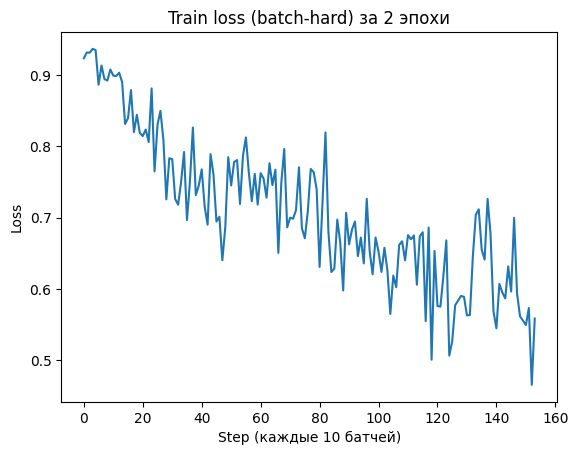

In [28]:
launch_experiment('triple_semi_hard') # 0.8051

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=0.1292
Batch 10/766: Loss=0.1615
Batch 20/766: Loss=0.1378
Batch 30/766: Loss=0.1350
Batch 40/766: Loss=0.1434
Batch 50/766: Loss=0.1373
Batch 60/766: Loss=0.1105
Batch 70/766: Loss=0.1302
Batch 80/766: Loss=0.1132
Batch 90/766: Loss=0.1138
Batch 100/766: Loss=0.1142
Batch 110/766: Loss=0.1320
Batch 120/766: Loss=0.1266
Batch 130/766: Loss=0.1336
Batch 140/766: Loss=0.1191
Batch 150/766: Loss=0.1275
Batch 160/766: Loss=0.0929
Batch 170/766: Loss=0.0855
Batch 180/766: Loss=0.0745
Batch 190/766: Loss=0.1121
Batch 200/766: Loss=0.0802
Batch 210/766: Loss=0.1108
Batch 220/766: Loss=0.1076
Batch 230/766: Loss=0.0957
Batch 240/766: Loss=0.0817
Batch 250/766: Loss=0.0757
Batch 260/766: Loss=0.1163
Batch 270/766: Loss=0.1124
Batch 280/766: Loss=0.0866
Batch 290/766: Loss=0.1193
Batch 300/766: Loss=0.0653
Batch 310/766: Loss=0.0755
Batch 320/766: Loss=0.1034
Batch 330/766: Loss=0.0678
Batch 340/766: Loss=0.0853
Batch 350/766: Loss=0.1145
Batch 360/766: Loss=

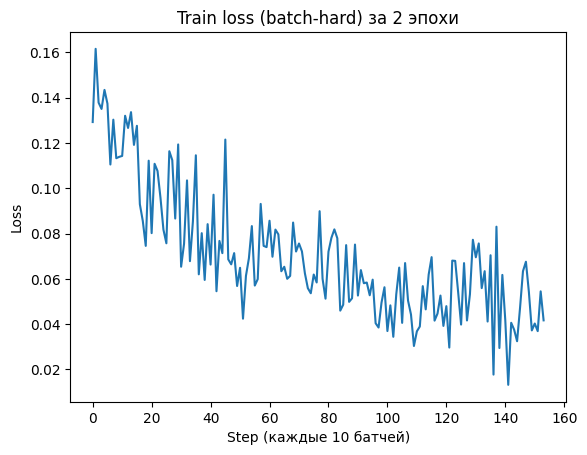

In [29]:
launch_experiment('triple_semi_hard', 0.2) # 0.8120

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=1.0945
Batch 10/766: Loss=0.8905
Batch 20/766: Loss=1.0108
Batch 30/766: Loss=1.0482
Batch 40/766: Loss=0.9826
Batch 50/766: Loss=0.9009
Batch 60/766: Loss=1.0231
Batch 70/766: Loss=1.0822
Batch 80/766: Loss=1.3826
Batch 90/766: Loss=1.0817
Batch 100/766: Loss=0.8941
Batch 110/766: Loss=1.3662
Batch 120/766: Loss=1.1936
Batch 130/766: Loss=0.8960
Batch 140/766: Loss=0.9140
Batch 150/766: Loss=0.8467
Batch 170/766: Loss=0.8924
Batch 180/766: Loss=0.8508
Batch 190/766: Loss=0.9222
Batch 200/766: Loss=1.1877
Batch 210/766: Loss=0.7157
Batch 220/766: Loss=0.9460
Batch 230/766: Loss=0.7632
Batch 240/766: Loss=0.8345
Batch 270/766: Loss=1.0204
Batch 280/766: Loss=0.9662
Batch 290/766: Loss=1.0948
Batch 300/766: Loss=0.7925
Batch 310/766: Loss=0.8909
Batch 320/766: Loss=0.5295
Batch 340/766: Loss=0.9992
Batch 350/766: Loss=1.0622
Batch 360/766: Loss=0.8727
Batch 370/766: Loss=0.0000
Batch 380/766: Loss=0.9775
Batch 390/766: Loss=0.5941
Batch 400/766: Loss=

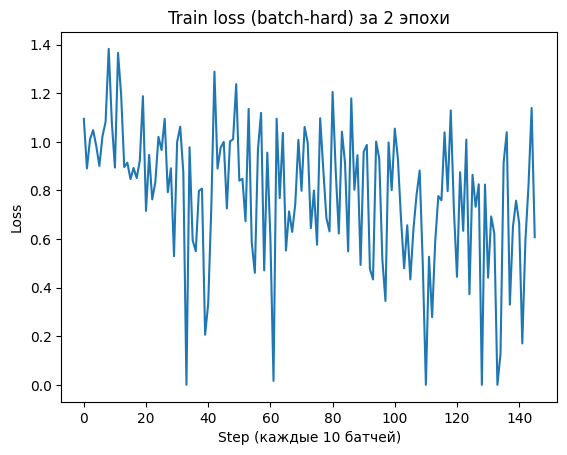

In [22]:
launch_experiment('triple_batch_hard') # 0.6986

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=0.4355
Batch 10/766: Loss=0.2328
Batch 20/766: Loss=0.2938
Batch 30/766: Loss=0.1279
Batch 40/766: Loss=0.2080
Batch 50/766: Loss=0.0902
Batch 60/766: Loss=0.2629
Batch 70/766: Loss=0.2370
Batch 80/766: Loss=0.2731
Batch 90/766: Loss=0.2282
Batch 100/766: Loss=0.1314
Batch 110/766: Loss=0.2168
Batch 120/766: Loss=0.2481
Batch 130/766: Loss=0.0759
Batch 140/766: Loss=0.1127
Batch 150/766: Loss=0.2006
Batch 160/766: Loss=0.3602
Batch 170/766: Loss=0.1958
Batch 180/766: Loss=0.1571
Batch 190/766: Loss=0.1571
Batch 200/766: Loss=0.2089
Batch 210/766: Loss=0.3254
Batch 230/766: Loss=0.0411
Batch 240/766: Loss=0.2386
Batch 250/766: Loss=0.0635
Batch 260/766: Loss=0.0064
Batch 270/766: Loss=0.2209
Batch 280/766: Loss=0.2520
Batch 290/766: Loss=0.0761
Batch 300/766: Loss=0.0796
Batch 310/766: Loss=0.0305
Batch 320/766: Loss=0.2050
Batch 330/766: Loss=0.1494
Batch 340/766: Loss=0.2576
Batch 350/766: Loss=0.1095
Batch 360/766: Loss=0.2218
Batch 370/766: Loss=

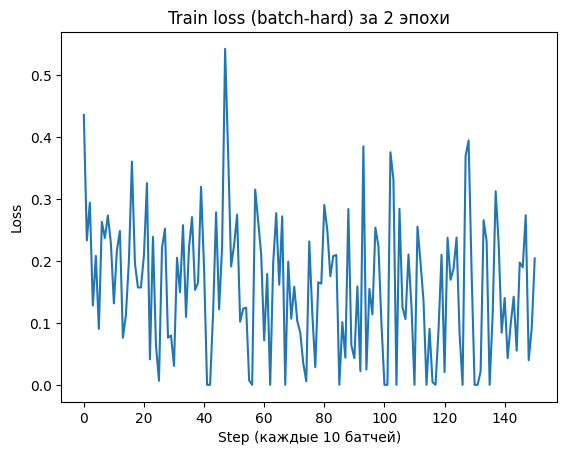

In [23]:
launch_experiment('triple_batch_hard', 0.2) # 0.7429

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=1.7696
Batch 10/766: Loss=1.6769
Batch 20/766: Loss=1.5823
Batch 30/766: Loss=1.6536
Batch 40/766: Loss=1.6406
Batch 50/766: Loss=1.5664
Batch 60/766: Loss=1.4843
Batch 70/766: Loss=1.5307
Batch 80/766: Loss=1.4020
Batch 90/766: Loss=1.3221
Batch 100/766: Loss=1.4766
Batch 110/766: Loss=1.3648
Batch 120/766: Loss=1.4407
Batch 130/766: Loss=1.4359
Batch 140/766: Loss=1.3672
Batch 150/766: Loss=1.3168
Batch 160/766: Loss=1.3427
Batch 170/766: Loss=1.2999
Batch 180/766: Loss=1.2975
Batch 190/766: Loss=1.2680
Batch 200/766: Loss=1.2719
Batch 210/766: Loss=1.2800
Batch 220/766: Loss=1.3359
Batch 230/766: Loss=1.3319
Batch 240/766: Loss=1.2854
Batch 250/766: Loss=1.2212
Batch 260/766: Loss=1.2621
Batch 270/766: Loss=1.1945
Batch 280/766: Loss=1.2149
Batch 290/766: Loss=1.2730
Batch 300/766: Loss=1.2245
Batch 310/766: Loss=1.1778
Batch 320/766: Loss=1.1577
Batch 330/766: Loss=1.1875
Batch 340/766: Loss=1.2042
Batch 350/766: Loss=1.1568
Batch 360/766: Loss=

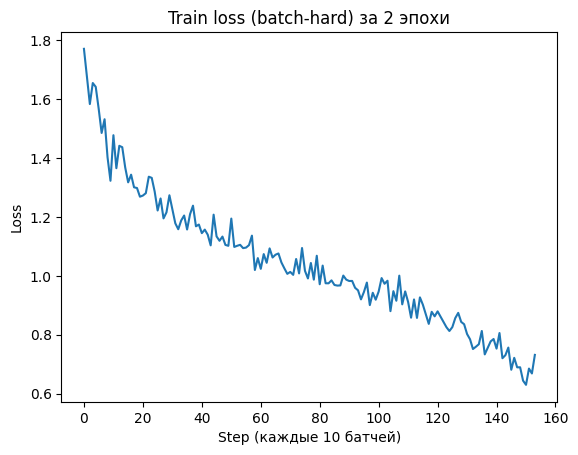

In [39]:
launch_experiment('triple_semi_hard', 0.2, use_proxy=True, proxy_coef=0.1) # 0.7988

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=15.3622
Batch 10/766: Loss=14.7747
Batch 20/766: Loss=14.9281
Batch 30/766: Loss=13.5294
Batch 40/766: Loss=13.5975
Batch 50/766: Loss=13.3830
Batch 60/766: Loss=12.7520
Batch 70/766: Loss=12.4567
Batch 80/766: Loss=11.7963
Batch 90/766: Loss=11.9599
Batch 100/766: Loss=11.2037
Batch 110/766: Loss=11.4550
Batch 120/766: Loss=11.4242
Batch 130/766: Loss=11.4959
Batch 140/766: Loss=10.6331
Batch 150/766: Loss=11.4305
Batch 160/766: Loss=10.4578
Batch 170/766: Loss=11.1420
Batch 180/766: Loss=10.1361
Batch 190/766: Loss=10.2108
Batch 200/766: Loss=10.0170
Batch 210/766: Loss=10.4686
Batch 220/766: Loss=10.4965
Batch 230/766: Loss=10.4247
Batch 240/766: Loss=10.2423
Batch 250/766: Loss=10.0912
Batch 260/766: Loss=10.1671
Batch 270/766: Loss=10.3771
Batch 280/766: Loss=9.7994
Batch 290/766: Loss=9.8381
Batch 300/766: Loss=9.5545
Batch 310/766: Loss=9.4893
Batch 320/766: Loss=9.6750
Batch 330/766: Loss=9.1910
Batch 340/766: Loss=10.1378
Batch 350/766: Los

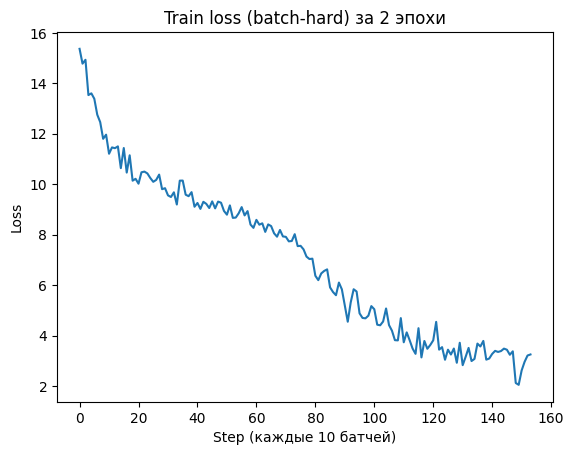

In [42]:
launch_experiment('triple_semi_hard', 0.2, use_proxy=True, proxy_coef=1.0, margin_lr=1e-4, proxy_lr=1e-4) # 0.7881

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=15.1403
Batch 10/766: Loss=15.3583
Batch 20/766: Loss=14.5935
Batch 30/766: Loss=13.6472
Batch 40/766: Loss=13.4642
Batch 50/766: Loss=13.3775
Batch 60/766: Loss=12.5502
Batch 70/766: Loss=12.9051
Batch 80/766: Loss=12.1387
Batch 90/766: Loss=11.5755
Batch 100/766: Loss=11.7070
Batch 110/766: Loss=10.7126
Batch 120/766: Loss=10.9088
Batch 130/766: Loss=11.2063
Batch 140/766: Loss=11.0462
Batch 150/766: Loss=10.9093
Batch 160/766: Loss=10.8450
Batch 170/766: Loss=10.4403
Batch 180/766: Loss=10.3146
Batch 190/766: Loss=10.3708
Batch 200/766: Loss=9.8310
Batch 210/766: Loss=10.2795
Batch 220/766: Loss=10.0073
Batch 230/766: Loss=10.0427
Batch 240/766: Loss=10.1462
Batch 250/766: Loss=9.8824
Batch 260/766: Loss=10.0766
Batch 270/766: Loss=9.7059
Batch 280/766: Loss=9.5059
Batch 290/766: Loss=9.7544
Batch 300/766: Loss=9.6057
Batch 310/766: Loss=9.6214
Batch 320/766: Loss=9.6306
Batch 330/766: Loss=9.3210
Batch 340/766: Loss=9.4415
Batch 350/766: Loss=9.

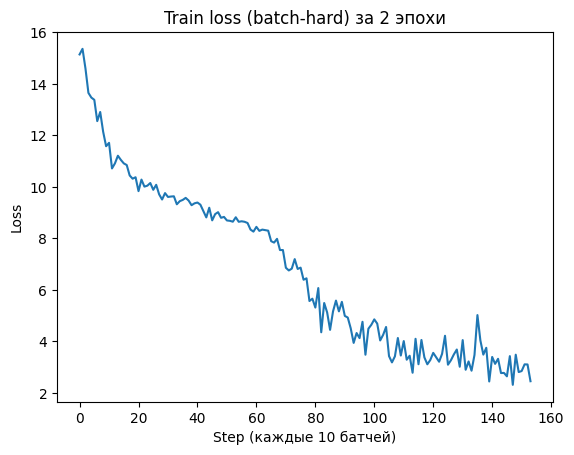

In [48]:
launch_experiment('triple_semi_hard', 0.2, use_proxy=True, proxy_coef=1.0, margin_lr=1e-4, proxy_lr=1e-3) # 0.8229

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=15.4903
Batch 10/766: Loss=13.1985
Batch 20/766: Loss=12.9667
Batch 30/766: Loss=11.6885
Batch 40/766: Loss=10.7006
Batch 50/766: Loss=10.8080
Batch 60/766: Loss=10.3687
Batch 70/766: Loss=10.4516
Batch 80/766: Loss=10.3040
Batch 90/766: Loss=10.5187
Batch 100/766: Loss=10.5808
Batch 110/766: Loss=10.4172
Batch 120/766: Loss=10.5223
Batch 130/766: Loss=10.2560
Batch 140/766: Loss=9.8572
Batch 150/766: Loss=9.7995
Batch 160/766: Loss=10.1346
Batch 170/766: Loss=9.5076
Batch 180/766: Loss=9.4180
Batch 190/766: Loss=9.5725
Batch 200/766: Loss=9.9852
Batch 210/766: Loss=9.1938
Batch 220/766: Loss=9.2737
Batch 230/766: Loss=9.1677
Batch 240/766: Loss=9.0345
Batch 250/766: Loss=8.7836
Batch 260/766: Loss=8.9817
Batch 270/766: Loss=8.3724
Batch 280/766: Loss=8.3241
Batch 290/766: Loss=8.5745
Batch 300/766: Loss=8.3535
Batch 310/766: Loss=8.2657
Batch 320/766: Loss=7.8530
Batch 330/766: Loss=7.7513
Batch 340/766: Loss=7.9001
Batch 350/766: Loss=7.5361
Batch

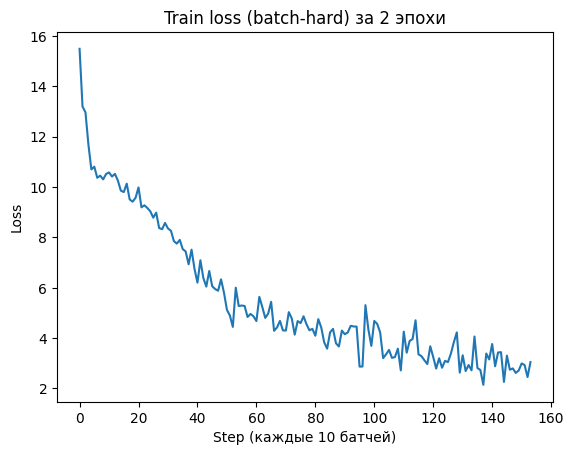

In [47]:
launch_experiment('triple_semi_hard', 0.2, use_proxy=True, proxy_coef=1.0, margin_lr=1e-4, proxy_lr=1e-2) # 0.8136

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=15.7314
Batch 10/766: Loss=14.4962
Batch 20/766: Loss=13.3979
Batch 30/766: Loss=12.5119
Batch 40/766: Loss=12.2545
Batch 50/766: Loss=11.6110
Batch 60/766: Loss=11.3799
Batch 70/766: Loss=11.4660
Batch 80/766: Loss=11.1331
Batch 90/766: Loss=11.2343
Batch 100/766: Loss=10.6468
Batch 110/766: Loss=10.4242
Batch 120/766: Loss=10.3191
Batch 130/766: Loss=10.3821
Batch 140/766: Loss=10.0195
Batch 150/766: Loss=10.0159
Batch 160/766: Loss=9.7438
Batch 170/766: Loss=10.4179
Batch 180/766: Loss=10.3386
Batch 190/766: Loss=9.7818
Batch 200/766: Loss=9.3786
Batch 210/766: Loss=9.9471
Batch 220/766: Loss=9.6788
Batch 230/766: Loss=9.4063
Batch 240/766: Loss=9.2231
Batch 250/766: Loss=9.2557
Batch 260/766: Loss=9.0958
Batch 270/766: Loss=9.5002
Batch 280/766: Loss=8.9236
Batch 290/766: Loss=9.0470
Batch 300/766: Loss=8.9454
Batch 310/766: Loss=8.9625
Batch 320/766: Loss=9.0228
Batch 330/766: Loss=8.7145
Batch 340/766: Loss=8.7794
Batch 350/766: Loss=8.6819
Ba

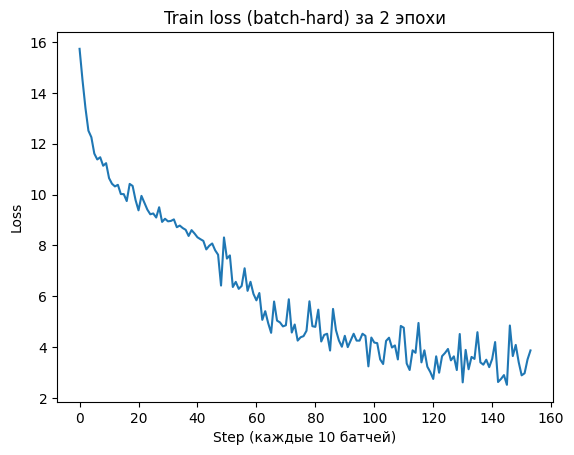

In [49]:
launch_experiment('triple_semi_hard', 0.2, use_proxy=True, proxy_coef=1.0, margin_lr=1e-4, proxy_lr=3e-3) # 0.7645

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.



=== Эпоха 1/2 ===
Batch 0/766: Loss=7.9604
Batch 10/766: Loss=7.6001
Batch 20/766: Loss=7.4848
Batch 30/766: Loss=7.1093
Batch 40/766: Loss=6.7205
Batch 50/766: Loss=6.6457
Batch 60/766: Loss=6.1921
Batch 70/766: Loss=6.2181
Batch 80/766: Loss=5.7832
Batch 90/766: Loss=5.7468
Batch 100/766: Loss=5.9972
Batch 110/766: Loss=5.8225
Batch 120/766: Loss=5.5219
Batch 130/766: Loss=5.6312
Batch 140/766: Loss=5.5313
Batch 150/766: Loss=5.6517
Batch 160/766: Loss=5.3554
Batch 170/766: Loss=5.5173
Batch 180/766: Loss=5.2039
Batch 190/766: Loss=5.3189
Batch 200/766: Loss=5.3467
Batch 210/766: Loss=5.0444
Batch 220/766: Loss=5.2332
Batch 230/766: Loss=5.1065
Batch 240/766: Loss=5.0036
Batch 250/766: Loss=4.8932
Batch 260/766: Loss=4.8462
Batch 270/766: Loss=4.9431
Batch 280/766: Loss=4.9536
Batch 290/766: Loss=4.7841
Batch 300/766: Loss=4.8947
Batch 310/766: Loss=4.7673
Batch 320/766: Loss=4.8168
Batch 330/766: Loss=4.8086
Batch 340/766: Loss=4.7402
Batch 350/766: Loss=4.8305
Batch 360/766: Loss=

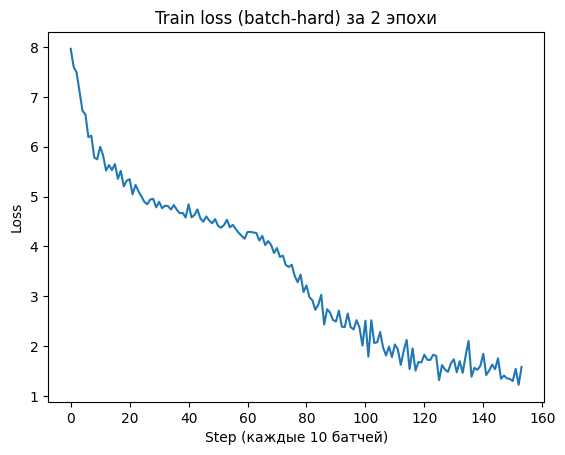

In [50]:
launch_experiment('triple_semi_hard', 0.2, use_proxy=True, proxy_coef=0.5, margin_lr=1e-4, proxy_lr=1e-3) # 0.8254

In [ ]:
import faiss
import numpy as np
import torch

def build_faiss_index(model, dataloader, device, embedding_dim):
    model.eval()
    all_embs = []
    all_labels = []
    with torch.no_grad():
        for anchor, _, _, anchor_label, _ in dataloader:
            anchor = anchor.to(device)
            emb = model(anchor)
            emb = emb.cpu().numpy().astype('float32')
            all_embs.append(emb)
            all_labels.extend(anchor_label.cpu().numpy())

    all_embs = np.vstack(all_embs)
    train_labels = np.array(all_labels)

    index = faiss.IndexFlatL2(embedding_dim)
    index.add(all_embs)

    return index, train_labels


def evaluate_faiss(model, index, train_labels, dataloader, device, k=5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for anchor, _, _, anchor_label, _ in dataloader:
            anchor = anchor.to(device)
            emb = model(anchor)
            emb = emb.cpu().numpy().astype('float32')

            distances, indices = index.search(emb, k)

            true = anchor_label.cpu().numpy()
            for i, t in enumerate(true):
                neigh = train_labels[indices[i]]
                vals, counts = np.unique(neigh, return_counts=True)
                pred = vals[np.argmax(counts)]
                if pred == t:
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy

In [66]:
model_path = \
    'model_triple_semi_hard_0_2_lr0_0001_proxy_0_5_lr0_001/model_epoch_2.pth'
backbone_name = 'levit_128'
embedding_dim = 128
model = EmbeddingNet(backbone_name=backbone_name, embedding_dim=embedding_dim, pretrained=False)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
None

/tmp/ipykernel_31488/3934292202.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 128
index, train_labels = build_faiss_index(model, train_loader, device, embedding_dim)

In [68]:
faiss_acc = evaluate_faiss(model, index, train_labels, val_loader, device, k=5)
print(f"FAISS top 5 accuracy: {faiss_acc * 100:.2f}%")

FAISS top 5 accuracy: 83.34%


In [69]:
faiss_acc = evaluate_faiss(model, index, train_labels, val_loader, device, k=3)
print(f"FAISS top 3 accuracy: {faiss_acc * 100:.2f}%")

FAISS top 3 accuracy: 83.00%


In [70]:
faiss_acc = evaluate_faiss(model, index, train_labels, val_loader, device, k=10)
print(f"FAISS top 10 accuracy: {faiss_acc * 100:.2f}%")

FAISS top 10 accuracy: 83.19%


In [71]:
faiss_acc = evaluate_faiss(model, index, train_labels, val_loader, device, k=1)
print(f"FAISS top 1 accuracy: {faiss_acc * 100:.2f}%")

FAISS top 1 accuracy: 82.83%
